In [27]:
import matplotlib.pyplot as plt
import matplotlib.animation
import pickle
import numpy as np
import networkx as nx
import seaborn as sns
from IPython.display import HTML

from saved files get:
- time series data
- environment
- final driver models

In [28]:
NAME = "data_dqn_grid_N100_I1000_S16_B4_EXP0.89_G0.9_LR0.01"
with open(NAME, "rb") as file:
    data = pickle.load(file)
# with open(f"dqn_grid_drivers_{NAME}", "rb") as file:
#     drivers = pickle.load(file)

In [29]:
success = [data[t]["success"].mean() for t in data.keys()]
travel_time = [data[t]["T"].mean() for t in data.keys()]

Text(0.5, 0, 'timestep')

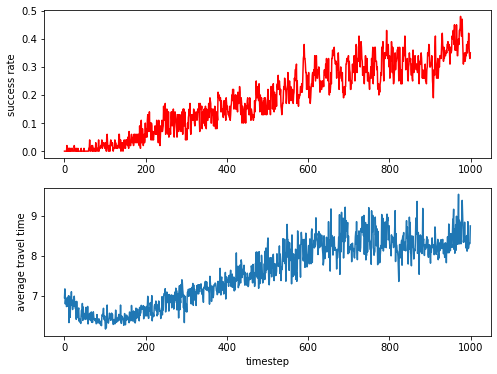

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
ax[0].plot(success, color="red")
ax[0].set_ylabel("success rate")
ax[1].plot(travel_time)
ax[1].set_ylabel("average travel time")
ax[1].set_xlabel("timestep")

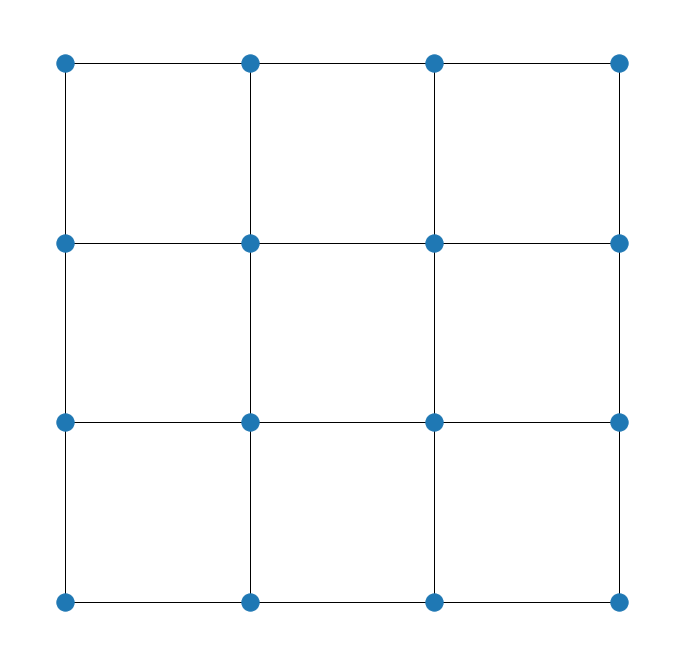

In [31]:
size = 4
G = nx.grid_graph(dim=(size, size))
for e in G.edges():
    G.edges[e]["cost"] = lambda x: 10 + x

positions = {node: node for node in G.nodes()}

# size = 4
# G = nx.DiGraph()
# G.add_nodes_from([(0, 0), (1, 1), (2, 2), (3, 3)])
# G.add_edges_from([
#     ((0, 0), (1, 1), {"cost": lambda x: x/100}),
#     ((0, 0), (2, 2), {"cost": lambda x: 1}),
#     ((1, 1), (2, 2), {"cost": lambda x: 0}),
#     ((1, 1), (3, 3), {"cost": lambda x: 1}),
#     ((2, 2), (3, 3), {"cost": lambda x: x/100}),
# ])
# positions = {(0,0): (0, 1), (1,1): (1,2), (2,2): (1,0), (3,3): (2,1)}


fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(G, pos=positions, ax=ax)
plt.show()

In [32]:
episodes = [data[t]["trajectory"] for t in data.keys()]

In [33]:
states_counts = []
edges_actions = []

for trajectory in episodes:
    for experience in trajectory:
        states_counts.append(experience[1])
        edges_actions.append(experience[2])

In [34]:
len(states_counts)

115501

In [37]:
def update(num):
    num = len(states_counts)-100+num

    ax.clear()
    occupied_states = states_counts[num].keys()
    occupied_states_counts = states_counts[num].values()
    
    nodes = set(G.nodes())
    occ_s = set([tuple(s) for s in occupied_states])
    
    node_labels = states_counts[num]
    
    # Background nodes
    nx.draw_networkx_edges(G, pos=positions, ax=ax, edge_color="gray")
    null_nodes = nx.draw_networkx_nodes(G, pos=positions, nodelist=nodes - occ_s, node_color="white",  ax=ax)
    null_nodes.set_edgecolor("black")

    # Query nodes
    query_nodes = nx.draw_networkx_nodes(
        G, 
        pos=positions, 
        nodelist=occ_s,
        node_size=1500,
#         node_color=[idx_colors[i] for i in occupied_states_counts], 
        ax=ax)
    query_nodes.set_edgecolor("white")
    nx.draw_networkx_labels(G, pos=positions, labels=node_labels, font_size = 15, font_color="white", ax=ax)
#     print(edges[num], edge_labels[num])
    
    # Traversed edges
    edgelist = edges_actions[num].keys()
    edge_labels = edges_actions[num]
    nx.draw_networkx_edges(G, 
                           pos=positions, 
                           edgelist=edgelist,
                           ax=ax)
    nx.draw_networkx_edge_labels(G, 
                           pos=positions, 
                           edge_labels=edge_labels,
                           ax=ax)

    # Scale plot ax
    # ax.set_title("Frame %d:    "%(num+1) +  " - ".join(path), fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])

In [38]:
ani = matplotlib.animation.FuncAnimation(fig, update, frames=100, interval=1000, repeat=True)
HTML(ani.to_jshtml())

## Visualize Driver Q-Values

In [24]:
import torch

In [25]:
drivers[0].policy_net(torch.tensor([0,0,0,1,0,0,0,1], dtype=torch.float32))

tensor([-0.5508, -0.4092, -0.7673, -0.8954], grad_fn=<AddBackward0>)

In [26]:
one_hot_enc = {(l, r): np.concatenate([
    np.array([0 if i != l else 1 for i in range(size)]), 
    np.array([0 if i != r else 1 for i in range(size)])
]) for(l, r) in G.nodes()}

In [27]:
avg_values = np.zeros((size, size, 1))
var_values = np.zeros((size, size, 1))

In [28]:
for i in range(size):
    for j in range(size):
        values = torch.zeros((100, 4))
        for n, driver in drivers.items():
            values[n] = driver.policy_net(torch.tensor(
                one_hot_enc[i, j], dtype=torch.float32))
        avg_values[i, j] = values.numpy(force=True).mean()
        var_values[i, j] = values.numpy(force=True).var(axis=0).mean()

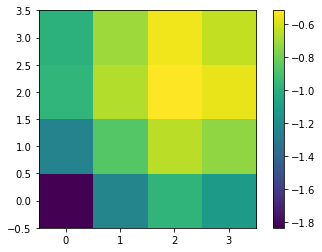

In [30]:
plt.imshow(avg_values, origin="lower")
plt.colorbar()

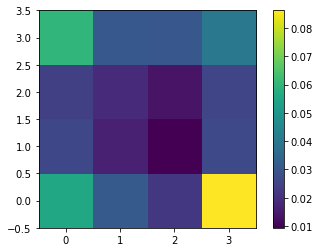

In [31]:
plt.imshow(var_values, origin="lower")
plt.colorbar()

In [58]:
edge_action_values = dict()
for node in G.nodes():
    values = torch.zeros((100, 4))
    for n, driver in drivers.items():
        values[n] = driver.policy_net(torch.tensor(
            one_hot_enc[node], dtype=torch.float32))
    values = values.numpy(force=True)
    for action, edge in enumerate(G.edges(node)):
        edge_action_values[edge] = values[:,action]

In [59]:
edge_labels = {}
for edge, action_values in list(edge_action_values.items()):
    x0, x1 = edge
    if sum(x0) > sum(x1):
        x0_x1_values = action_values.mean()
        x1_x0_values = edge_action_values[(x1, x0)].mean()
        edge_labels[(x1, x0)] = f"{-1*x0_x1_values:.2f} ---- {-1*x1_x0_values:.2f}"

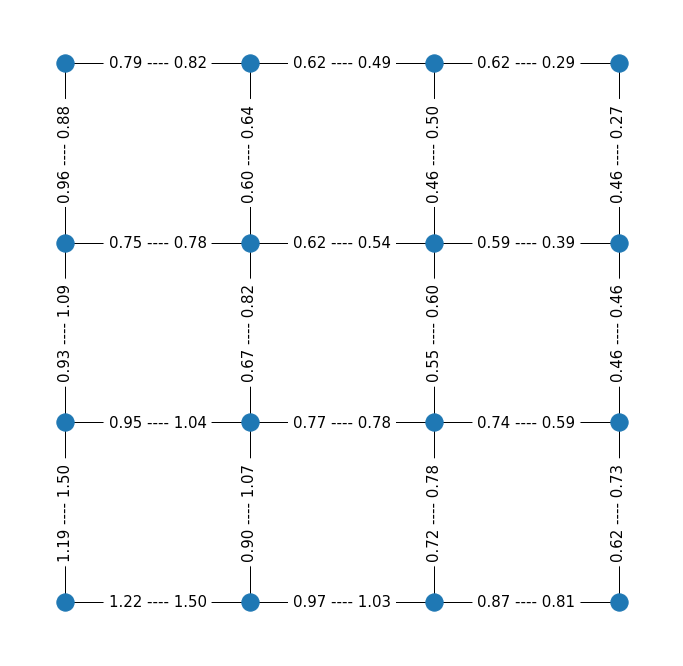

In [60]:
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw(G, pos=positions, ax=ax)
nx.draw_networkx_edge_labels(G, 
                           pos=positions, 
                           edge_labels=edge_labels,
                           ax=ax,
                            font_size=15)
plt.show()

In [62]:
from collections import defaultdict

In [69]:
a = {0: 0}
defaultdict(lambda: 0, a)

defaultdict(<function __main__.<lambda>()>, {0: 0})

In [72]:
list(G.edges((0,0))) + list(G.edges((0,1)))

[((0, 0), (1, 0)),
 ((0, 0), (0, 1)),
 ((0, 1), (0, 0)),
 ((0, 1), (1, 1)),
 ((0, 1), (0, 2))]